In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from ripser import ripser
from persim import plot_diagrams

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig

In [2]:
# função que define os dados
def start_points(n = 100, r = 1, eps = 0.2):
    ps = []
    n = 100
    for i in range(n):
        theta = np.random.uniform(0, 2 * np.pi)
        eps = np.random.uniform(-0.2, 0.2)
        x, y  = (r + eps) * np.cos(theta), (r + eps) * np.sin(theta)
        ps += [[x,y]]
    return np.array([np.array(q) for q in ps])

In [3]:
data = start_points()

In [4]:
diagrams = ripser(data, thresh=1)['dgms'] #thresh é maior valor de epsilon que a função considera

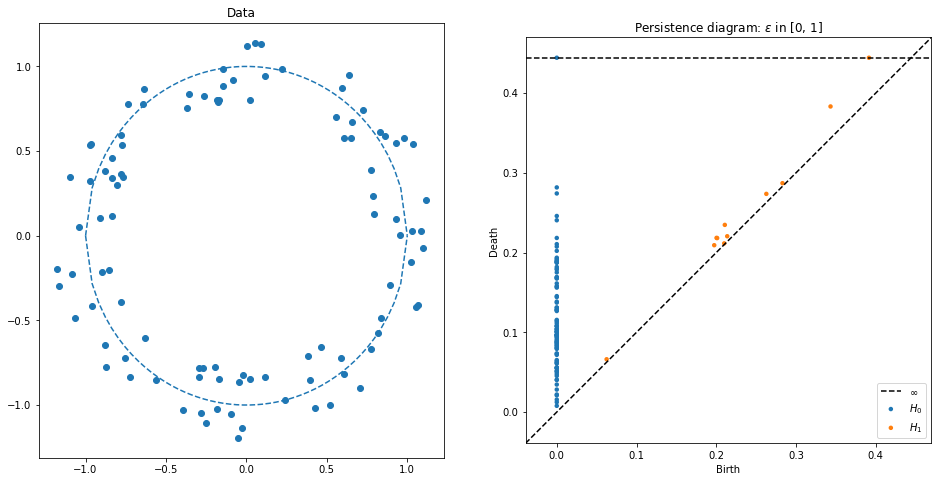

In [5]:
# verificando que os pontos estão perto de um círculo
fig, ax = plt.subplots(1, 2, figsize = (16,8))

ax[0].set_title('Data')
ax[1].set_title(r'Persistence diagram: $\epsilon$ in [0, 1]')

ax[0].scatter([q[0] for q in data], [q[1] for q in data])
ax[0].plot(np.linspace(-1,1), np.sqrt(1 - np.linspace(-1, 1) ** 2), '--', color = 'tab:blue')
ax[0].plot(np.linspace(-1,1), -np.sqrt(1 - np.linspace(-1, 1) ** 2), '--', color = 'tab:blue')
plot_diagrams(diagrams, show=True)

plt.show()

In [6]:
eps = 0.4
G = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps)

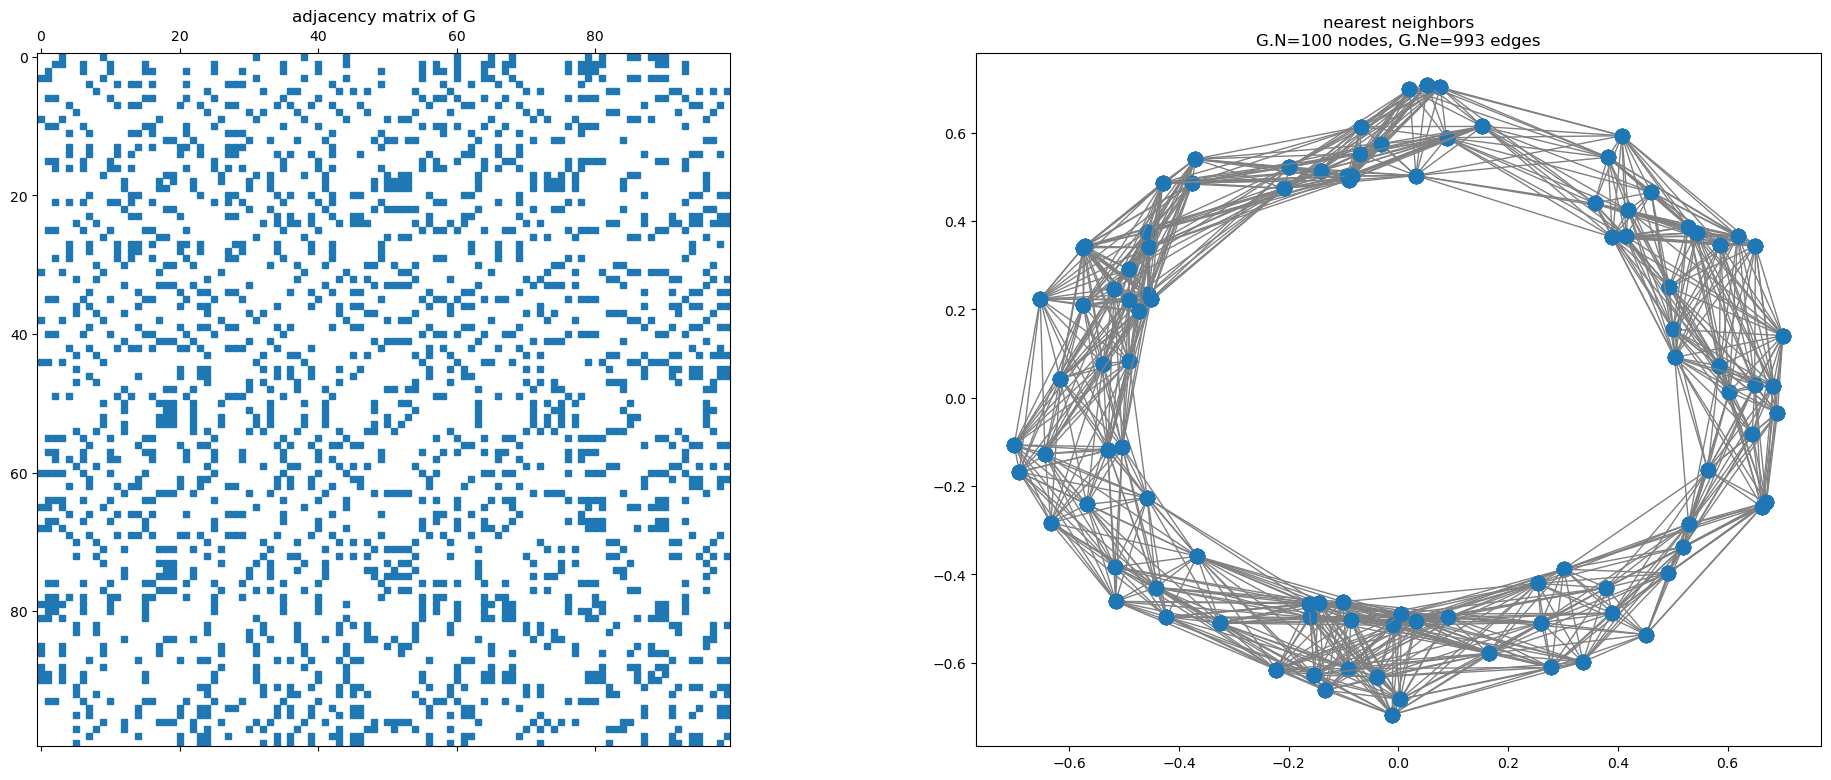

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (24, 9))
ax[0].spy(G.W, markersize=5)
# G.plot(ax=axes[1])
G.plot(ax=ax[1])

ax[0].set_title("adjacency matrix of G")
plt.show()

In [8]:
G.compute_fourier_basis() #demora
V = G.U
Λ = np.diag(G.e)
matrix_rank(V)

100

In [9]:
k = 76
np.shape(V[:,:k]) #[:,:k] pega só as primeiras k colunas

(100, 76)

In [10]:
def sampling_matrix(V, k):
    m = np.shape(V)[0]
    ψ = np.hstack((np.identity(k), np.zeros((k, m - k))))
    return ψ

def interpolation_matrix(ψ, V, k):
    U = inv(ψ @ V[:, :k])
    return U, V[:, :k] @ U

In [11]:
ψ = sampling_matrix(V, k)
matrix_rank(ψ @ V[:, :k]), np.shape(ψ) #tamanho certo k x |V| e rank certo

(76, (76, 100))

In [12]:
%%time
U, φ = interpolation_matrix(ψ, V, k) #é pra demorar

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.3 ms


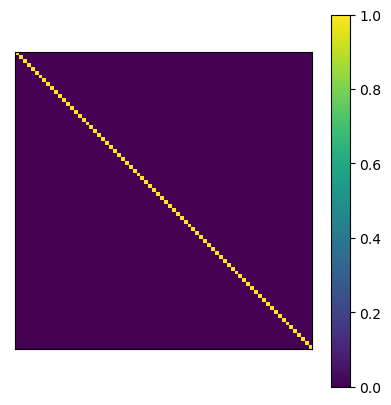

In [13]:
plt.matshow(U @ ψ @ V[:, :k]) #testando se U ψ V_(k) da realmente a identidade
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
M = φ @ ψ

In [15]:
rs = np.random.RandomState(12345)
coefs = rs.uniform(10 * np.ones(k))

signal = V[:, :k] @ coefs
reconstructed_signal = M @ signal

In [16]:
h = np.arange(0, 100, 1) < k

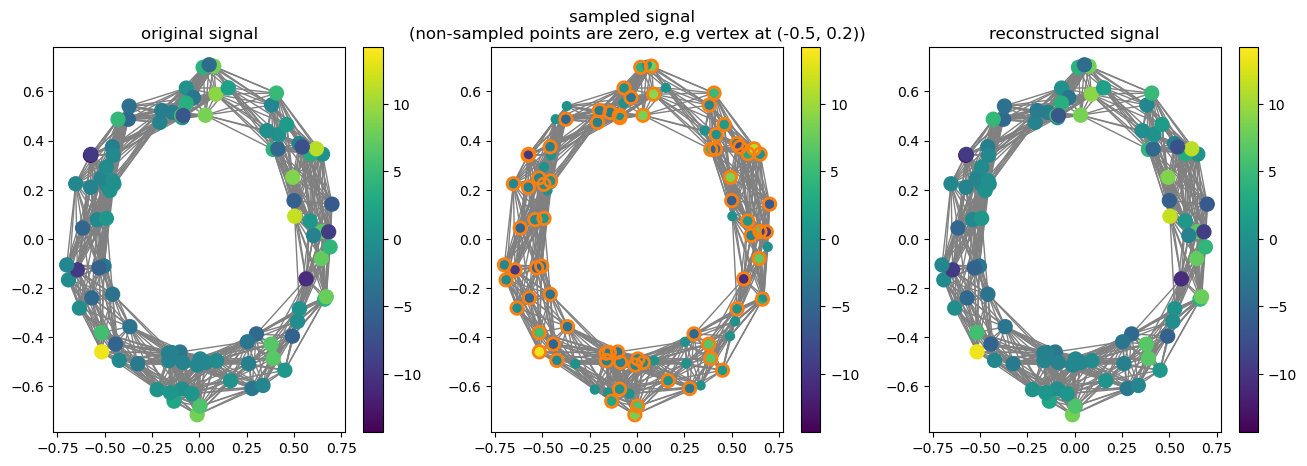

In [17]:
fig, ax = plt.subplots(1,3, figsize = (16,5))
G.plot_signal(signal, ax = ax[0])
G.plot_signal(np.hstack((ψ @ signal, 0 * np.ones(G.N - k))), vertex_size = 40, highlight = h, ax = ax[1], )
G.plot_signal(reconstructed_signal, ax = ax[2])
ax[0].set_title('original signal')
ax[1].set_title('sampled signal  \n(non-sampled points are zero, e.g vertex at (-0.5, 0.2))')
ax[2].set_title('reconstructed signal')
plt.show()

In [18]:
%%time
U_inv = inv(U) #é pra demorar

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 422 µs


In [19]:
new_shift = U_inv @ Λ[:k,:k] @ U

In [20]:
(np.hstack((U @ ψ @ signal, 0 * np.ones(G.N - k))) - V.T @ signal).max() #frequencias "iguais"

4.2388315080188477e-10

In [21]:
def optimal_sampling_operator(Vk, m, sort = True, verbose = False):
    M = []
    n = np.shape(Vk)[0]
    check_list = list(np.arange(0, n, 1, dtype = int))
    while len(M) < m:
        c = 0
        i = 0
        for j in check_list:
            if j in M:
                continue
            d = min(np.linalg.svd(Vk[M + [i]])[1])
            if d >= c:
                i = j
                c = d
        check_list.remove(i)
        M += [i]
        if verbose:
            print(len(check_list))
    if sort:
        M.sort()
    return M

In [22]:
i = 76
opt_indexes = optimal_sampling_operator(V[:, :i], i, sort = False)

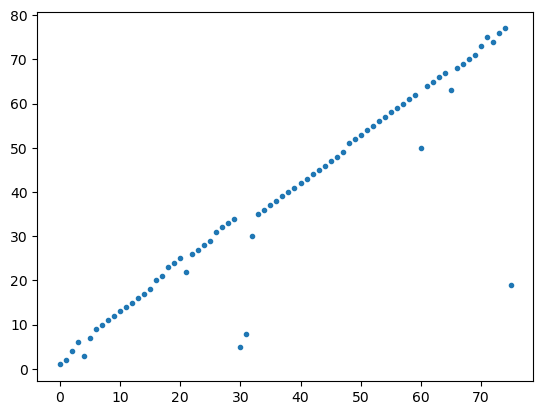

In [23]:
# plt.figure(figsize = (10,10))
plt.plot(opt_indexes, '.')
# plt.yticks(opt_indexes)
plt.show()

In [24]:
def sample_indexes(V, indexes):
    ψ = np.zeros((np.shape(V)[0], np.shape(V)[0]))
    for i in indexes:
        ψ[i][i] = 1
    return ψ
def opt_matrices(V, indexes):
    k = len(indexes)
    ψ = np.zeros((k, np.shape(V)[0]))
    for i, o_i in enumerate(indexes):
        ψ[i][o_i] = 1
    U = inv(ψ @ V[:, :k])
    φ = V[:, :k] @ U
    return ψ, φ, U, V[:, :k]

In [25]:
sampling_matrix = sample_indexes(V, opt_indexes)
# ψ_opt, φ_opt, U_opt, Vk =  opt_matrices(V, [1,2,3,4,5,6])
ψ_opt, φ_opt, U_opt, Vk =  opt_matrices(V, opt_indexes)
M_opt = φ_opt @ ψ_opt

In [26]:
sampled_signal = ψ_opt @ signal
reconstructed_signal_opt = φ_opt @ sampled_signal
h = [j in opt_indexes for j in np.arange(0, 100, 1)]

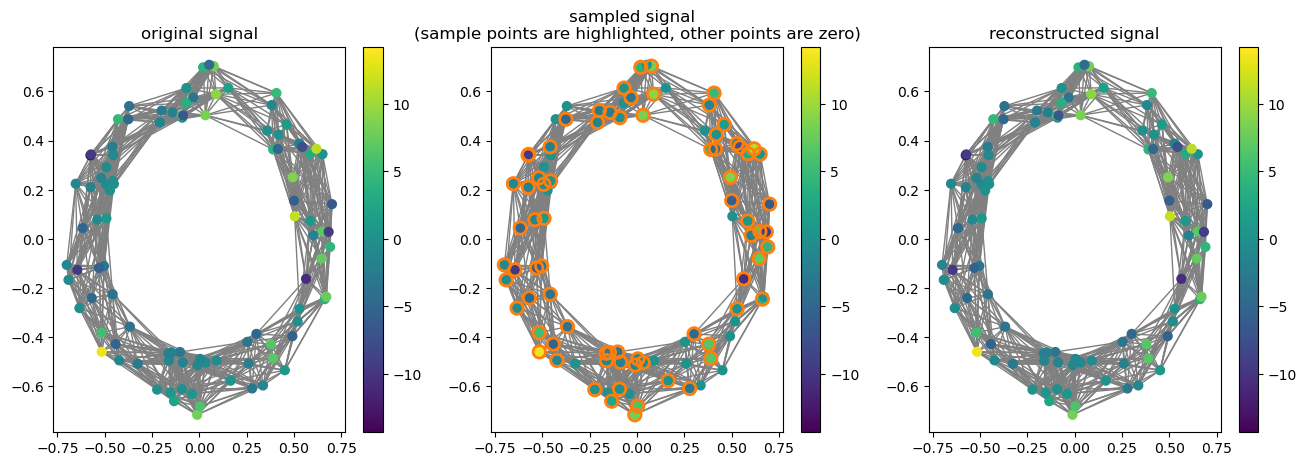

In [27]:
fig, ax = plt.subplots(1,3, figsize = (16,5))
G.plot_signal(signal, vertex_size = 40, ax = ax[0])
G.plot_signal(sampling_matrix @ signal, vertex_size = 40, highlight = h, ax = ax[1], )
G.plot_signal(reconstructed_signal_opt, vertex_size = 40, ax = ax[2])
ax[0].set_title('original signal')
ax[1].set_title('sampled signal  \n(sample points are highlighted, other points are zero)')
ax[2].set_title('reconstructed signal')
plt.show()

In [28]:
max(signal - reconstructed_signal_opt)

1.6292387883254378e-08

# Grid graph

In [268]:
H = p.graphs.Grid2d(35,35)
grid_k = 5

In [269]:
%%time
ws, es = eig(H.W.todense())
es = es.T.real

CPU times: user 3.89 s, sys: 78.1 ms, total: 3.97 s
Wall time: 510 ms


In [270]:
# H.compute_fourier_basis()
Vh = es

In [271]:
opt_indexes_grid = optimal_sampling_operator(es[:, :grid_k], grid_k, sort = False)

In [272]:
rs_grid = np.random.RandomState(12745)
coefs_grid = rs_grid.uniform(10 * np.ones(grid_k))

signal_grid = es[:, :grid_k] @ coefs_grid

In [273]:
coefs_grid

array([8.22604537, 3.36415824, 2.17227629, 4.66528821, 6.51663186])

In [274]:
h = [j in opt_indexes_grid for j in np.arange(0, 35 * 35, 1)]
opt_indexes_grid

[2, 7, 3, 1, 4]

In [275]:
sampling_matrix_grid = sample_indexes(Vh, opt_indexes_grid)
ψ_grid_opt, φ_grid_opt, U_grid_opt, Vhk =  opt_matrices(Vh, opt_indexes_grid)
# ψ_grid_opt, φ_grid_opt, U_grid_opt, Vhk =  opt_matrices(Vh, [1,2,3,4,5])
M_grid_opt = φ_grid_opt @ ψ_grid_opt

In [276]:
sampled_grid_signal = ψ_grid_opt @ signal_grid
reconstructed_grid_signal_opt = φ_grid_opt @ sampled_grid_signal

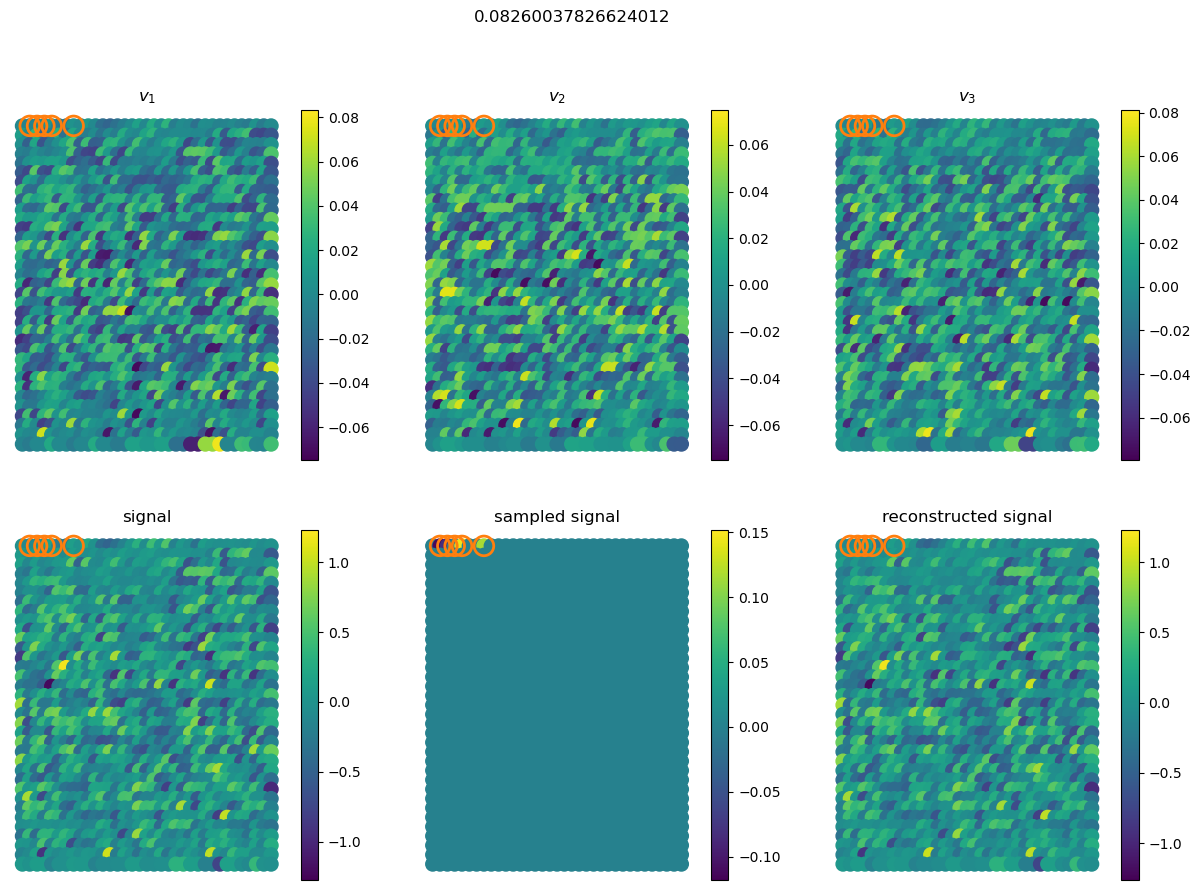

In [277]:
titles = [r'$v_1$', r'$v_2$', r'$v_3$', 'signal', 'sampled signal', 'reconstructed signal']
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
signals = [Vh.T[2], Vh.T[3], Vh.T[4], signal_grid, sampling_matrix_grid @ signal_grid, reconstructed_grid_signal_opt]
for i in [0,1]:
    for j in [0,1,2]:
        ax[i][j].axis('off')
        H.plot_signal(signals[3 * i + j], ax = ax[i][j], vertex_size = 100, highlight = h)
        ax[i][j].set_title(titles[3 * i + j])
fig.suptitle(max(abs(signal_grid - reconstructed_grid_signal_opt)))
plt.show()

In [234]:
q = np.array([[0,1], [1,0]])

In [240]:
ws, es = eig(q)
es = es.T

In [241]:
q @ es[0] == ws[0] * es[0]

array([ True,  True])

In [246]:
%%time
ws, es = eig(H.W.todense())
es = es.T

CPU times: user 3.89 s, sys: 62.5 ms, total: 3.95 s
Wall time: 528 ms


In [248]:
H.W @ es[0] == ws[0] * es[0]

np.isclose(H.W @ es[0], ws[0] * es[0])

array([ True,  True,  True, ...,  True,  True,  True])